- Apply self-attention mechanism on DCGAN
- ref: https://github.com/taki0112/Self-Attention-GAN-Tensorflow

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import os
import gc
import tqdm
import random
import glob

import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, callbacks, layers, losses
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Input, Reshape, Conv2D, Conv2DTranspose, Flatten, MaxPooling2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow_addons as tfa

tf.random.set_seed(SEED)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
        
def mish(x):
    return x*tf.math.tanh(tf.math.softplus(x))

def leakyrelu(x, factor=0.2):
    return tf.maximum(x, factor*x)

In [3]:
def ConvBlock(n, kernel_size=3, strides=2, bn=True, padding='same'):
    def f(x):
        x = Conv2D(n, kernel_size=kernel_size, strides=strides, padding=padding)(x)
        x = Activation(leakyrelu)(x)       
        if bn:
            x = BatchNormalization(momentum=0.8)(x)
        return x
    return f

def deConvBlock(n, kernel_size=3, strides=2, bn=True, padding='same'):
    def f(x):
        x = Conv2DTranspose(n, kernel_size=kernel_size, strides=strides, padding=padding)(x)
        x = Activation('relu')(x)       
        if bn:
            x = BatchNormalization(momentum=0.8)(x)
        return x
    return f

def hw_flatten(x):
    return tf.reshape(x, shape=[tf.shape(x)[0], tf.shape(x)[1]*tf.shape(x)[2], tf.shape(x)[-1]])
        
def Attention(ch):
    def f(x):
        gamma = tf.Variable(initial_value=0, trainable=True, dtype=tf.float32)

        f = Conv2D(ch//8, kernel_size=1, strides=1, padding='same')(x)
        g = Conv2D(ch//8, kernel_size=1, strides=1, padding='same')(x)
        h = Conv2D(ch, kernel_size=1, strides=1, padding='same')(x)

        s = tf.matmul(hw_flatten(g), hw_flatten(f), transpose_b=True)

        beta = tf.nn.softmax(s)

        o = tf.matmul(beta, hw_flatten(h))
        o = tf.reshape(o, shape=tf.shape(x))
        x = gamma*o + x

        return x
    return f

In [4]:
class SAGAN(keras.Model):
    def __init__(self, x_dim, z_dim): # dim: tuple
        super(SAGAN, self).__init__()
        self.x_dim = x_dim
        self.z_dim = z_dim

        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        
    def compile(self, g_optim, d_optim, loss_fn):
        super(SAGAN, self).compile()
        self.g_optim = g_optim
        self.d_optim = d_optim
        self.loss_fn = loss_fn
        
    def build_generator(self): 
        inputs = Input(shape = self.z_dim)
        
        x = Dense(128*7*7, activation='relu')(inputs)
        x = Reshape((7, 7, 128))(x) # 7, ,7 128
        x = BatchNormalization(momentum=0.8)(x)
        x = deConvBlock(64)(x) # 14, 14, 64
        x = Attention(64)(x)
        x = deConvBlock(32)(x) # 28, 28, 32
        x = Attention(32)(x)
        
        outputs = Conv2D(1, kernel_size=3, strides=1, activation='tanh', padding='same')(x) # 28, 28, 1
        return Model(inputs, outputs, name='generator')

    def build_discriminator(self):
        inputs = Input(shape = self.x_dim)
        
        x = ConvBlock(16)(inputs)
        x = Attention(16)(x)
        x = ConvBlock(32)(x)
        x = ConvBlock(64)(x)
        x = Flatten()(x)
        
        outputs = Dense(1)(x)
        return Model(inputs, outputs, name='discriminator')
    
    def train_step(self, x):
        batch_size = tf.shape(x)[0]
        
        fake_labels = tf.ones((batch_size, 1))
        real_labels = tf.ones((batch_size, 1))*0
        labels = tf.concat([real_labels, fake_labels], 0)
        
        noise = tf.random.normal((batch_size, self.z_dim))
        
        # discriminator
        with tf.GradientTape() as tape:
            fake = self.generator(noise)
            all_x = tf.concat([x, fake], 0)
            preds = self.discriminator(all_x)
            
            d_loss = self.loss_fn(labels, preds)

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optim.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # generator
        with tf.GradientTape() as tape:
            fake = self.generator(noise)
            preds = self.discriminator(fake)

            g_loss = self.loss_fn(real_labels, preds)
            
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optim.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {'d_loss': d_loss, 'g_loss': g_loss}

In [5]:
class PlotCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            r, c = 2, 5
            noise = np.random.normal(0, 1, (r*c, 100))
            imgs = self.model.generator.predict(noise)*0.5 +0.5
            imgs = imgs.reshape(r*c, 28, 28)
            fig, axs = plt.subplots(r, c)
            n = 0
            for i in range(r):
                for j in range(c):
                    axs[i,j].imshow(imgs[n], cmap='gray')
                    axs[i,j].axis('off')
                    n += 1
            plt.show()
            plt.close()

In [6]:
# prepare data
from tensorflow.keras.datasets import mnist
(train_X, train_y), (_, _) = mnist.load_data()
train_X = (train_X - 127.5)/127.5
train_X = np.expand_dims(train_X, -1)


In [7]:
shape = train_X.shape[1:]
gan = SAGAN(shape, 100)

In [8]:
gan.generator.summary()
gan.discriminator.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 6272)         633472      input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 7, 7, 128)    0           dense[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 7, 7, 128)    512         reshape[0][0]                    
__________________________________________________________________________________________

In [9]:
gan.compile(
    optimizers.Adam(2e-4, 0.5), 
    optimizers.Adam(2e-4, 0.5), 
    losses.BinaryCrossentropy(from_logits=True), 
         )

Epoch 1/101
1875/1875 [==============================] - ETA: 0s - d_loss: 0.5941 - g_loss: 0.9652

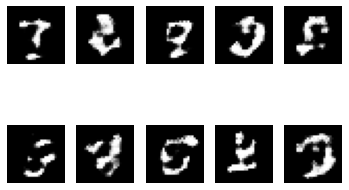

1875/1875 [==============================] - 21s 11ms/step - d_loss: 0.5942 - g_loss: 0.9651
Epoch 2/101
1875/1875 [==============================] - 21s 11ms/step - d_loss: 0.6505 - g_loss: 0.7986
Epoch 3/101
1875/1875 [==============================] - 21s 11ms/step - d_loss: 0.6563 - g_loss: 0.7895
Epoch 4/101
1875/1875 [==============================] - 19s 10ms/step - d_loss: 0.6670 - g_loss: 0.7811
Epoch 5/101
1875/1875 [==============================] - 21s 11ms/step - d_loss: 0.6677 - g_loss: 0.7735
Epoch 6/101
1875/1875 [==============================] - 19s 10ms/step - d_loss: 0.6710 - g_loss: 0.7685
Epoch 7/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6724 - g_loss: 0.7661
Epoch 8/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6750 - g_loss: 0.7606
Epoch 9/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6767 - g_loss: 0.7547
Epoch 10/101
1875/1875 [==============================] - 20s 11ms/

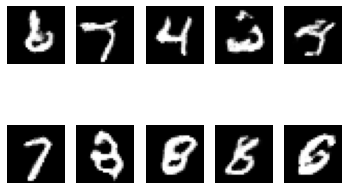

1875/1875 [==============================] - 20s 11ms/step - d_loss: 0.6788 - g_loss: 0.7521
Epoch 12/101
1875/1875 [==============================] - 20s 10ms/step - d_loss: 0.6794 - g_loss: 0.7490
Epoch 13/101
1875/1875 [==============================] - 19s 10ms/step - d_loss: 0.6808 - g_loss: 0.7460
Epoch 14/101
1875/1875 [==============================] - 20s 11ms/step - d_loss: 0.6811 - g_loss: 0.7462
Epoch 15/101
1875/1875 [==============================] - 21s 11ms/step - d_loss: 0.6816 - g_loss: 0.7433
Epoch 16/101
1875/1875 [==============================] - 20s 11ms/step - d_loss: 0.6821 - g_loss: 0.7424
Epoch 17/101
1875/1875 [==============================] - 21s 11ms/step - d_loss: 0.6830 - g_loss: 0.7398
Epoch 18/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6827 - g_loss: 0.7396
Epoch 19/101
1875/1875 [==============================] - 21s 11ms/step - d_loss: 0.6830 - g_loss: 0.7392
Epoch 20/101
1875/1875 [==============================] - 2

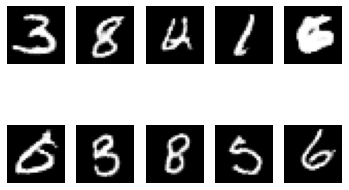

1875/1875 [==============================] - 21s 11ms/step - d_loss: 0.6834 - g_loss: 0.7370
Epoch 22/101
1875/1875 [==============================] - 20s 11ms/step - d_loss: 0.6836 - g_loss: 0.7364
Epoch 23/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6843 - g_loss: 0.7344
Epoch 24/101
1875/1875 [==============================] - 20s 11ms/step - d_loss: 0.6843 - g_loss: 0.7343
Epoch 25/101
1875/1875 [==============================] - 20s 11ms/step - d_loss: 0.6846 - g_loss: 0.7333
Epoch 26/101
1875/1875 [==============================] - 20s 11ms/step - d_loss: 0.6842 - g_loss: 0.7329
Epoch 27/101
1875/1875 [==============================] - 19s 10ms/step - d_loss: 0.6845 - g_loss: 0.7333
Epoch 28/101
1875/1875 [==============================] - 20s 11ms/step - d_loss: 0.6847 - g_loss: 0.7321
Epoch 29/101
1875/1875 [==============================] - 20s 11ms/step - d_loss: 0.6848 - g_loss: 0.7316
Epoch 30/101
1875/1875 [==============================] - 2

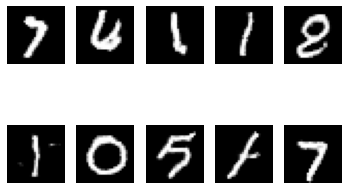

1875/1875 [==============================] - 19s 10ms/step - d_loss: 0.6846 - g_loss: 0.7313
Epoch 32/101
1875/1875 [==============================] - 20s 11ms/step - d_loss: 0.6853 - g_loss: 0.7305
Epoch 33/101
1875/1875 [==============================] - 21s 11ms/step - d_loss: 0.6853 - g_loss: 0.7304
Epoch 34/101
1875/1875 [==============================] - 20s 10ms/step - d_loss: 0.6854 - g_loss: 0.7297
Epoch 35/101
1875/1875 [==============================] - 21s 11ms/step - d_loss: 0.6849 - g_loss: 0.7313
Epoch 36/101
1875/1875 [==============================] - 19s 10ms/step - d_loss: 0.6850 - g_loss: 0.7304
Epoch 37/101
1875/1875 [==============================] - 20s 11ms/step - d_loss: 0.6851 - g_loss: 0.7299
Epoch 38/101
1875/1875 [==============================] - 21s 11ms/step - d_loss: 0.6855 - g_loss: 0.7296
Epoch 39/101
1875/1875 [==============================] - 20s 11ms/step - d_loss: 0.6847 - g_loss: 0.7307
Epoch 40/101
1875/1875 [==============================] - 2

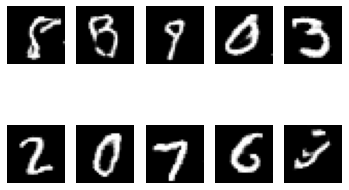

1875/1875 [==============================] - 21s 11ms/step - d_loss: 0.6856 - g_loss: 0.7288
Epoch 42/101
1875/1875 [==============================] - 19s 10ms/step - d_loss: 0.6856 - g_loss: 0.7286
Epoch 43/101
1875/1875 [==============================] - 20s 11ms/step - d_loss: 0.6854 - g_loss: 0.7288
Epoch 44/101
1875/1875 [==============================] - 20s 11ms/step - d_loss: 0.6859 - g_loss: 0.7282
Epoch 45/101
1875/1875 [==============================] - 20s 10ms/step - d_loss: 0.6854 - g_loss: 0.7290
Epoch 46/101
1875/1875 [==============================] - 20s 11ms/step - d_loss: 0.6859 - g_loss: 0.7284
Epoch 47/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6853 - g_loss: 0.7293
Epoch 48/101
1875/1875 [==============================] - 19s 10ms/step - d_loss: 0.6856 - g_loss: 0.7286
Epoch 49/101
1875/1875 [==============================] - 20s 11ms/step - d_loss: 0.6860 - g_loss: 0.7284
Epoch 50/101
1875/1875 [==============================] - 2

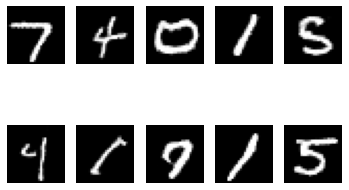

1875/1875 [==============================] - 20s 11ms/step - d_loss: 0.6854 - g_loss: 0.7286
Epoch 52/101
1875/1875 [==============================] - 20s 11ms/step - d_loss: 0.6851 - g_loss: 0.7294
Epoch 53/101
1875/1875 [==============================] - 21s 11ms/step - d_loss: 0.6856 - g_loss: 0.7285
Epoch 54/101
1875/1875 [==============================] - 20s 11ms/step - d_loss: 0.6852 - g_loss: 0.7294
Epoch 55/101
1875/1875 [==============================] - 20s 11ms/step - d_loss: 0.6854 - g_loss: 0.7289
Epoch 56/101
1875/1875 [==============================] - 20s 11ms/step - d_loss: 0.6860 - g_loss: 0.7282
Epoch 57/101
1875/1875 [==============================] - 21s 11ms/step - d_loss: 0.6856 - g_loss: 0.7291
Epoch 58/101
1875/1875 [==============================] - 20s 11ms/step - d_loss: 0.6858 - g_loss: 0.7290
Epoch 59/101
1875/1875 [==============================] - 19s 10ms/step - d_loss: 0.6854 - g_loss: 0.7289
Epoch 60/101
1875/1875 [==============================] - 2

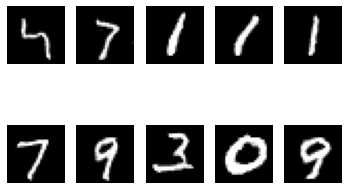

1875/1875 [==============================] - 20s 11ms/step - d_loss: 0.6851 - g_loss: 0.7294
Epoch 62/101
1875/1875 [==============================] - 20s 11ms/step - d_loss: 0.6852 - g_loss: 0.7302
Epoch 63/101
1875/1875 [==============================] - 20s 11ms/step - d_loss: 0.6853 - g_loss: 0.7300
Epoch 64/101
1875/1875 [==============================] - 20s 11ms/step - d_loss: 0.6850 - g_loss: 0.7301
Epoch 65/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6853 - g_loss: 0.7300
Epoch 66/101
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6851 - g_loss: 0.7303
Epoch 67/101
1875/1875 [==============================] - 21s 11ms/step - d_loss: 0.6850 - g_loss: 0.7296
Epoch 68/101
1875/1875 [==============================] - 20s 11ms/step - d_loss: 0.6853 - g_loss: 0.7304
Epoch 69/101
1875/1875 [==============================] - 19s 10ms/step - d_loss: 0.6851 - g_loss: 0.7302
Epoch 70/101
1875/1875 [==============================] - 2

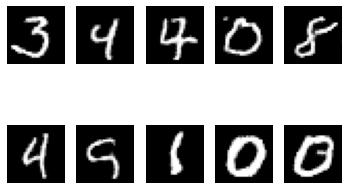

1875/1875 [==============================] - 20s 11ms/step - d_loss: 0.6850 - g_loss: 0.7312
Epoch 72/101
1875/1875 [==============================] - 20s 11ms/step - d_loss: 0.6848 - g_loss: 0.7316
Epoch 73/101
1875/1875 [==============================] - 16s 9ms/step - d_loss: 0.6846 - g_loss: 0.7317
Epoch 74/101
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6844 - g_loss: 0.7325
Epoch 75/101
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6843 - g_loss: 0.7325
Epoch 76/101
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6849 - g_loss: 0.7317
Epoch 77/101
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6845 - g_loss: 0.7321
Epoch 78/101
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6847 - g_loss: 0.7323
Epoch 79/101
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6845 - g_loss: 0.7329
Epoch 80/101
1875/1875 [==============================] - 17s 9ms/

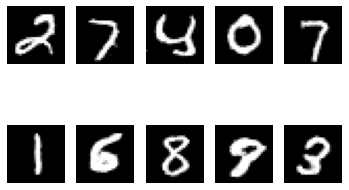

1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6843 - g_loss: 0.7328
Epoch 82/101
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6842 - g_loss: 0.7333
Epoch 83/101
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6842 - g_loss: 0.7336
Epoch 84/101
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6842 - g_loss: 0.7331
Epoch 85/101
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6842 - g_loss: 0.7333
Epoch 86/101
1875/1875 [==============================] - 16s 9ms/step - d_loss: 0.6840 - g_loss: 0.7344
Epoch 87/101
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6842 - g_loss: 0.7338
Epoch 88/101
1875/1875 [==============================] - 16s 9ms/step - d_loss: 0.6843 - g_loss: 0.7337
Epoch 89/101
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6841 - g_loss: 0.7336
Epoch 90/101
1875/1875 [==============================] - 17s 9ms/st

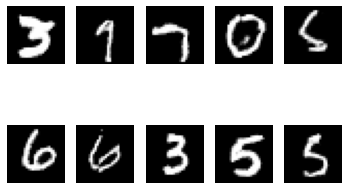

1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6844 - g_loss: 0.7336
Epoch 92/101
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6839 - g_loss: 0.7347
Epoch 93/101
1875/1875 [==============================] - 16s 9ms/step - d_loss: 0.6833 - g_loss: 0.7358
Epoch 94/101
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6839 - g_loss: 0.7358
Epoch 95/101
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6841 - g_loss: 0.7346
Epoch 96/101
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6833 - g_loss: 0.7361
Epoch 97/101
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6839 - g_loss: 0.7349
Epoch 98/101
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6840 - g_loss: 0.7352
Epoch 99/101
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6837 - g_loss: 0.7353
Epoch 100/101
1875/1875 [==============================] - 17s 9ms/s

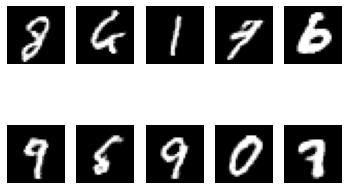

1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6837 - g_loss: 0.7358


In [10]:
gan.fit(train_X,
       epochs=101,
       shuffle=True,
       callbacks=[PlotCallback()],
       batch_size=32)